<a href="https://colab.research.google.com/github/Akankshaaaa/Image-deblurring/blob/main/imageDeblurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deblurring of textual images

In [ ]:
## imports
%matplotlib inline 

import cv2
import numpy as np
import random
from random import choice
import os
from google.colab.patches import cv2_imshow
from skimage.io import imsave
from posix import XATTR_REPLACE
from sklearn.model_selection import train_test_split
import glob
import tensorflow as tf
import keras
from keras import models, layers
from keras.layers import Conv2D, UpSampling2D
from keras.preprocessing import image
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, Input, regularizers
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/imageDeblur
!ls

##Dataset creation
In this project we have only implemented deblurring of textual images that have a gaussian blur. However, we can also experiment with images having motion blur. Here we have included functions to add a motion blur and gaussian blur. Motion blur can be of type vertical or horizontal. The following function randomly performs either of the two motion blur methods. For both motion and gaussian blur, we have kernel size to be set randomly between a certain range.

In [ ]:
# function to add motion blur
# motion blur can be added horizonatally and vertically

def motion_blur(img):

  # setting random kernel size between 5 to 8
  # The greater the size, the more the motion
  kernel_size = random.randrange(5,9)
  
  # Create the vertical kernel.
  kernel_v = np.zeros((kernel_size, kernel_size))
  
  # Create a copy of the same for creating the horizontal kernel.
  kernel_h = np.copy(kernel_v)


  #randomly select between 0 and 1
  num = random.randint(0, 1)
  
  # if num is 0, do vertical motion blur
  if num == 0:

    # Fill the middle row with ones.
    kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)

    # Normalize.
    kernel_v /= kernel_size

    # Apply the vertical kernel.
    vertical_mb = cv2.filter2D(img, -1, kernel_v)

    return vertical_mb
  # similarly, if num is 1, do a horizontal motion blur
  else:
    kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
    kernel_h /= kernel_size
    horizontal_mb = cv2.filter2D(img, -1, kernel_h)
    return horizontal_mb


In [ ]:
# function to add gaussian blur

def gaussian_blur(img):
  # setting random kernel size between 5 to 15
  kernel_size = random.randrange(5,16,2)
  gausBlur = cv2.GaussianBlur(img, (kernel_size,kernel_size),0)
  return gausBlur



####For creating a dataset of motion and gaussian blur images

In [ ]:
# generate blurred images dataset
# the images will be blurred using either gaussian or vertical/horizontal motion blur

for filename in os.listdir('/content/drive/MyDrive/imageDeblur/dataset/og_images'):
        path = os.path.join('/content/drive/MyDrive/imageDeblur/dataset/og_images',filename)
        img = cv2.imread(path)
        print(filename)
        filename = filename[0:-8]

        # which blur to use is selected at random
        blurring = [motion_blur, gaussian_blur]
        imsave("/content/drive/MyDrive/imageDeblur/dataset/blur_images/"+filename+"blur.png", (choice(blurring)(img)))



####For creating a dataset of only gaussian blur images

In [ ]:
# generate blurred images dataset
# the images will be blurred using gaussian blur

for filename in os.listdir('/content/drive/MyDrive/imageDeblur/dataset/og_images'):
        path = os.path.join('/content/drive/MyDrive/imageDeblur/dataset/og_images',filename)
        img = cv2.imread(path)
        print(filename)
        filename = filename[0:-8]

        imsave("/content/drive/MyDrive/imageDeblur/dataset/gauss_images/"+filename+"blur.png", gaussian_blur(img))



In [ ]:
# verify the count of pngs in both og and blur images 
%cd /content/drive/MyDrive/imageDeblur/dataset/og_images
!ls -F | grep .png | wc -l

%cd /content/drive/MyDrive/imageDeblur/dataset/gauss_images

!ls -F | grep .png | wc -l



/content/drive/MyDrive/imageDeblur/dataset/og_images
4177
/content/drive/MyDrive/imageDeblur/dataset/gauss_images
4177


##Dataset Preprocessing

In [ ]:

X = []  #data i.e blurred images
Y = []  #labels i.e sharp images

def gen_images_X():
    for i in sorted(glob.glob("/content/drive/MyDrive/imageDeblur/dataset/gauss_images/*.*")):
        img =tf.keras.preprocessing.image.load_img(i, color_mode='grayscale',
        target_size= (256,256))
        img=np.array(img , dtype='float32') 
        img /= 255.
        yield img

def gen_images_Y():
    for i in sorted(glob.glob("/content/drive/MyDrive/imageDeblur/dataset/og_images/*.*")):
        img =tf.keras.preprocessing.image.load_img(i, color_mode='grayscale',
        target_size= (256,256))
        img=np.array(img , dtype='float32') 
        img /= 255.
        yield img

for img in gen_images_X():
    X.append(img)

for img in gen_images_Y():
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(4177, 256, 256)
(4177, 256, 256)


In [ ]:
# train test split
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.25)
print(X_train.shape)
print(X_test.shape)

(3132, 256, 256)
(1045, 256, 256)


##Model

In [ ]:
Input_img = Input(shape=(256, 256, 1))  
  
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(1, (3, 3), padding='same')(x1)

model = Model(Input_img, decoded)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 256)     2560      
                                                                 
 conv2d_8 (Conv2D)           (None, 256, 256, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      36928     
                                                           

##Training

Epoch 1/10
157/157 [==============================] - 413s 3s/step - loss: 0.0841 - accuracy: 0.6736 - val_loss: 0.0185 - val_accuracy: 0.7223
Epoch 2/10
157/157 [==============================] - 394s 3s/step - loss: 0.0149 - accuracy: 0.7199 - val_loss: 0.0123 - val_accuracy: 0.7244
Epoch 3/10
157/157 [==============================] - 394s 3s/step - loss: 0.0119 - accuracy: 0.7210 - val_loss: 0.0111 - val_accuracy: 0.7247
Epoch 4/10
157/157 [==============================] - 394s 3s/step - loss: 0.0110 - accuracy: 0.7213 - val_loss: 0.0104 - val_accuracy: 0.7250
Epoch 5/10
157/157 [==============================] - 394s 3s/step - loss: 0.0102 - accuracy: 0.7215 - val_loss: 0.0098 - val_accuracy: 0.7252
Epoch 6/10
157/157 [==============================] - 394s 3s/step - loss: 0.0099 - accuracy: 0.7217 - val_loss: 0.0091 - val_accuracy: 0.7254
Epoch 7/10
157/157 [==============================] - 395s 3s/step - loss: 0.0094 - accuracy: 0.7218 - val_loss: 0.0088 - val_accuracy: 0.7254

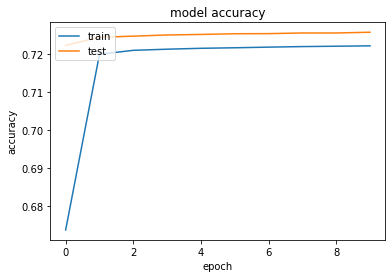

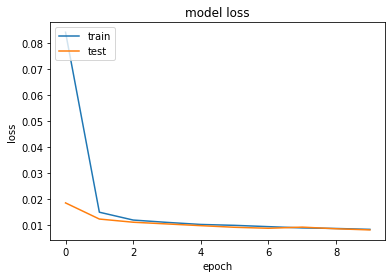

In [ ]:
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

#training
history = model.fit(X_train,Y_train,validation_split=0.2, epochs=10, batch_size=16, shuffle=True) 
                    # callbacks=[early_stopper])


model.save('/content/drive/MyDrive/imageDeblur/models/gauss_deblurring_v7.model')

#plot epochs vs loss and accuracy graphs
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [ ]:
#load previous model
model = tf.keras.models.load_model(
    '/content/drive/MyDrive/imageDeblur/models/gauss_deblurring_v4.model',
    custom_objects=None,
    compile=True)

## Evaluating model performance

In [ ]:
# Evaluate accuracy on test data
print("Evaluate on test data")
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Evaluate on test data
33/33 [==============================] - 76s 2s/step - loss: 0.0088 - accuracy: 0.7163
accuracy: 71.63%


## Testing

In [ ]:
# test images for gauss

test = []
def gen_images_test():
    for i in sorted(glob.glob("/content/drive/MyDrive/imageDeblur/gauss_test_images/*.*")):
        img =tf.keras.preprocessing.image.load_img(i, color_mode='grayscale',
        target_size= (256,256))
        img=np.array(img , dtype='float32') 
        img /= 255.
        yield img

for img in gen_images_test():
    test.append(img)

test = np.array(test)



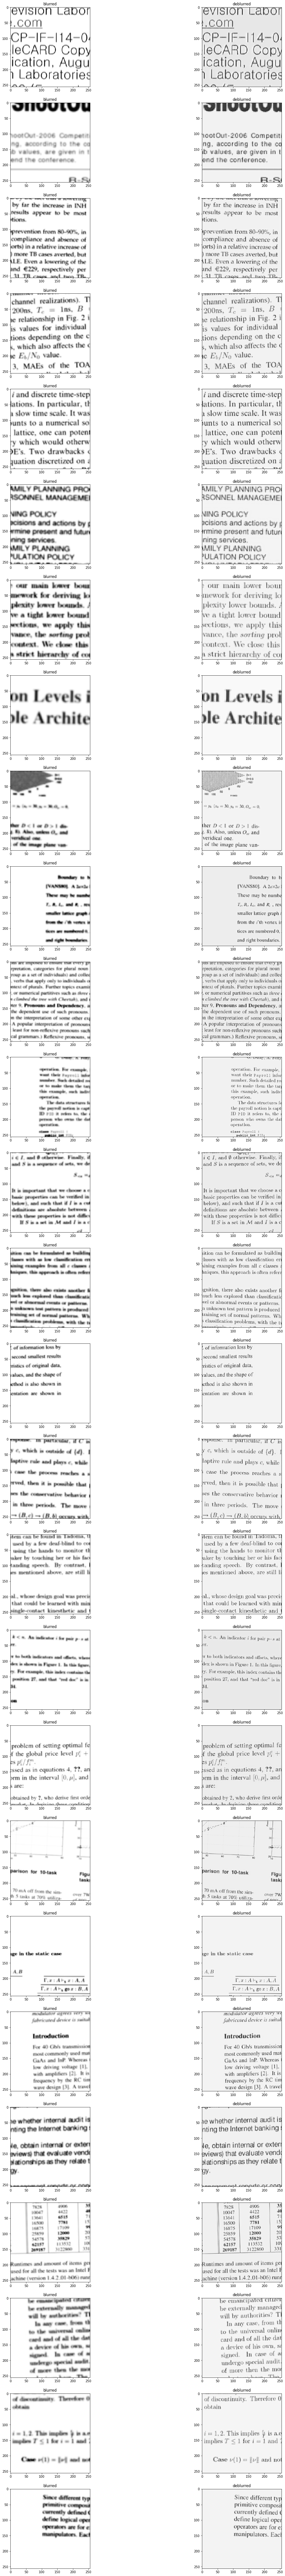

In [ ]:
# results of g_v7 on gauss

output = model.predict(test)
plt.figure(figsize= (20,150))

num = 27
for i in range(num):
		# load the image and mask
		image = test[i]
		op = output[i]
		# define subplot
		plt.subplot(num, 2, i*2+1)
		# plot raw pixel data
		plt.imshow(image, cmap="Greys_r")

		plt.title('blurred')
		plt.subplot(num, 2, i*2+2)
		
    # plot raw pixel data
		plt.imshow(op[:,:,0], cmap="Greys_r")
		plt.title('deblurred')


plt.show()
